In [23]:
import numpy as np  # Importa la biblioteca NumPy bajo el alias 'np' para realizar cálculos numéricos.
from shapely.ops import split  # Importa la función 'split' desde Shapely para realizar operaciones de división en geometrías.
import geopandas as gpd  # Importa la biblioteca GeoPandas bajo el alias 'gpd' para el análisis de datos geoespaciales.
from shapely.geometry import MultiPolygon, Polygon, LineString  # Importa varios tipos de geometrías desde Shapely para representar formas geométricas en el espacio.
import ee
import geojson

In [24]:
def descargar_imagen_landsat8(geometry, fecha_inicio, fecha_fin, tipoImagen):
  band = ['B4', 'B3', 'B2']

  # Inicializar la API de Google Earth Engine
  ee.Initialize()

  # Definir la geometría
  geometry = ee.Geometry.Polygon(
    [geometry], None, False);
  
  IMGLandsat8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_RT_TOA') \
      .filterDate(fecha_inicio, fecha_fin) \
      .filterBounds(geometry) \
      .filterMetadata('CLOUD_COVER', 'less_than', 20)

  # Obtener la imagen mediana
  Landsat8Filtro = IMGLandsat8.median()

  # Recortar la imagen con la geometría
  Landsat8Clip = Landsat8Filtro.clip(geometry)



  imagenRGB = Landsat8Clip.visualize(**{'min': 0,'max': 0.5, 'bands': band})
  extension = 'jpg'

  url = imagenRGB.getThumbURL({ 'region': geometry, 'dimensions': 500, 'format': extension })
  

  return url

In [25]:
# Ruta del archivo de datos geoespaciales (Shapefile) que se va a leer.
geo_filepath = "shapefiles/nombre_shapefile.shp"

In [26]:
# Lee el archivo Shapefile especificado en 'geo_filepath' y lo carga en un GeoDataFrame (GeoDF).
GeoDF = gpd.read_file(geo_filepath)


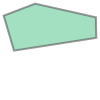

In [27]:
# Selecciona una geometría aleatoria del GeoDataFrame 'GeoDF' y almacénala en la variable 'G'.

G = np.random.choice(GeoDF.geometry.values)
G

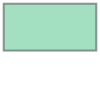

In [28]:
# Calcula la envolvente (rectángulo delimitador) de la geometría almacenada en 'G' y almacena el resultado en 'Rectangle'.
Rectangle = G.envelope
Rectangle

In [29]:
# Longitud del lado de la celda
side_length = 0.02

# Obtiene las coordenadas de la envolvente del rectángulo y las almacena en 'rect_coords'
rect_coords = np.array(Rectangle.boundary.coords.xy)

# Extrae las listas de coordenadas x e y de 'rect_coords'
y_list = rect_coords[1]
x_list = rect_coords[0]

# Calcula los valores mínimos y máximos de las coordenadas y para obtener la altura del rectángulo
y1 = min(y_list)
y2 = max(y_list)

# Calcula los valores mínimos y máximos de las coordenadas x para obtener el ancho del rectángulo
x1 = min(x_list)
x2 = max(x_list)

# Calcula el ancho y la altura del rectángulo
width = x2 - x1
height = y2 - y1

# Calcula el número de celdas en la dirección x e y, redondeando al entero más cercano
xcells = int(np.round(width / side_length))
ycells = int(np.round(height / side_length))

# Crea una serie de índices igualmente espaciados en las direcciones x e y
yindices = np.linspace(y1, y2, ycells + 1)
xindices = np.linspace(x1, x2, xcells + 1)
width,height


(0.16712254711580954, 0.0846144563997484)

In [30]:
# Crea una lista de líneas horizontales que atraviesan el rectángulo delimitador en direcciones verticales.
horizontal_splitters = [
    LineString([(x, yindices[0]), (x, yindices[-1])]) for x in xindices
]

# Imprime la lista de líneas horizontales.
horizontal_splitters

[<LINESTRING (-73.138 -36.783, -73.138 -36.699)>,
 <LINESTRING (-73.117 -36.783, -73.117 -36.699)>,
 <LINESTRING (-73.096 -36.783, -73.096 -36.699)>,
 <LINESTRING (-73.075 -36.783, -73.075 -36.699)>,
 <LINESTRING (-73.054 -36.783, -73.054 -36.699)>,
 <LINESTRING (-73.034 -36.783, -73.034 -36.699)>,
 <LINESTRING (-73.013 -36.783, -73.013 -36.699)>,
 <LINESTRING (-72.992 -36.783, -72.992 -36.699)>,
 <LINESTRING (-72.971 -36.783, -72.971 -36.699)>]

In [31]:
# Crea una lista de líneas verticales que atraviesan el rectángulo delimitador en direcciones horizontales.
vertical_splitters = [
    LineString([(xindices[0], y), (xindices[-1], y)]) for y in yindices
]

# Imprime la lista de líneas verticales.
vertical_splitters

[<LINESTRING (-73.138 -36.783, -72.971 -36.783)>,
 <LINESTRING (-73.138 -36.762, -72.971 -36.762)>,
 <LINESTRING (-73.138 -36.741, -72.971 -36.741)>,
 <LINESTRING (-73.138 -36.72, -72.971 -36.72)>,
 <LINESTRING (-73.138 -36.699, -72.971 -36.699)>]

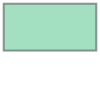

In [32]:
# Asigna la geometría del rectángulo delimitador original a la variable 'result'.
result = Rectangle

# Imprime 'result', que ahora contiene la misma geometría que 'Rectangle'.
result

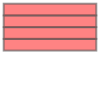

In [33]:
# Itera sobre la lista de líneas verticales 'vertical_splitters' y divide la geometría 'result' en múltiples polígonos.
for splitter in vertical_splitters:
    result = MultiPolygon(split(result, splitter))

# Imprime 'result', que ahora contiene los polígonos resultantes después de la división.
result

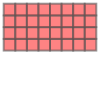

In [34]:
# Itera sobre la lista de líneas horizontales 'horizontal_splitters' y divide la geometría 'result' en múltiples polígonos.
for splitter in horizontal_splitters:
    result = MultiPolygon(split(result, splitter))

# Imprime 'result', que ahora contiene los polígonos resultantes después de la división horizontal y vertical.
result


In [35]:
# Extrae los polígonos individuales del resultado final 'result' y los almacena en la lista 'square_polygons'.
square_polygons = list(result.geoms)
len(square_polygons)


32

In [36]:
# Crea un GeoDataFrame a partir de la lista de polígonos 'square_polygons'.
df = gpd.GeoDataFrame(square_polygons)


In [37]:
# Crea un nuevo GeoDataFrame a partir de la lista de polígonos 'square_polygons'.
SquareGeoDF  = gpd.GeoDataFrame(square_polygons).rename(columns={0: "geometry"})

In [38]:
# Crea un nuevo GeoDataFrame a partir de la lista de polígonos 'square_polygons'.
SquareGeoDF = gpd.GeoDataFrame(square_polygons)

# Establece la geometría del GeoDataFrame en la primera columna (índice 0) de los datos.
SquareGeoDF = SquareGeoDF.set_geometry(0)


In [39]:
# Extrae las geometrías de 'SquareGeoDF' que se intersectan con la geometría 'G' y las almacena en 'Geoms'.
Geoms = SquareGeoDF[SquareGeoDF.intersects(G)].geometry.values

# Define una variable 'shape' con el valor "square".
shape = "square"

# Define una variable 'thresh' con el valor 0.9.
thresh = 0.2

In [40]:
# Si la variable 'shape' es igual a "rhombus", realiza las siguientes operaciones.
if shape == "rhombus":
    # Aplica una función 'rhombus(g)' a cada geometría en 'Geoms' y almacena los resultados en 'Geoms'.
    #Geoms = [rhombus(g) for g in Geoms]
    # Filtra las geometrías en 'Geoms' que cumplen con una condición de área y las almacena en 'geoms'.
    geoms = [g for g in Geoms if ((g.intersection(G)).area / g.area) >= thresh]

# Si la variable 'shape' es igual a "square", realiza las siguientes operaciones.
elif shape == "square":
   
    # Filtra las geometrías en 'Geoms' que cumplen con una condición de área y las almacena en 'geoms'.
    geoms = [g for g in Geoms if ((g.intersection(G)).area / g.area) >= thresh]

geoms
len(geoms)

27

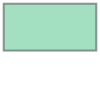

In [41]:
Rectangle

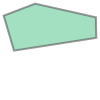

In [42]:
G

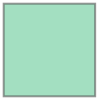

In [52]:
from PIL import Image
index = 1
geoms[26]



In [93]:
import geopandas as gpd
import matplotlib.pyplot as plt
from PIL import Image
print(type(geoms))
# Supongamos que ya tienes 'geoms' definido
grid = gpd.GeoDataFrame({'geometry': geoms})

index = 1
for sq in geoms:
    xx, yy = sq.exterior.coords.xy
    x = xx.tolist()
    y = yy.tolist()
    
    ruta_imagen = "./imagenes/subimagen/Sub_Landsat8_2018-01-01_2019-01-01_" + str(index) + ".jpg"
    
    try:
        imagen = Image.open(ruta_imagen)
        grid.loc[index - 1, 'image'] = imagen
        #print(f"Imagen cargada para index {index}: {ruta_imagen}")
    except Exception as e:
        print(f"Error al cargar la imagen para index {index}: {str(e)}")
    
    index += 1



<class 'list'>


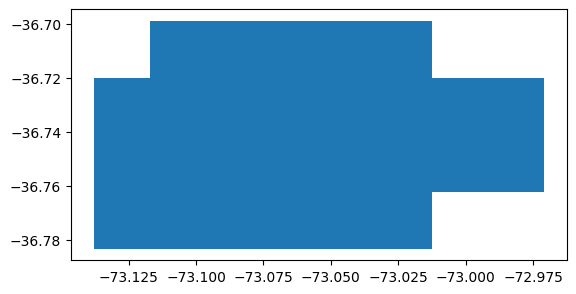

In [75]:
grid = gpd.GeoDataFrame({'geometry':geoms})
geoms

index = 1
for sq in geoms:
  xx, yy = sq.exterior.coords.xy
  x = xx.tolist()
  y = yy.tolist()
  print(list(zip(x,y)))
  url = descargar_imagen_landsat8(list(zip(x,y)), "2018-01-01","2019-01-01", "True Color")
  #print(url)

grid.plot();

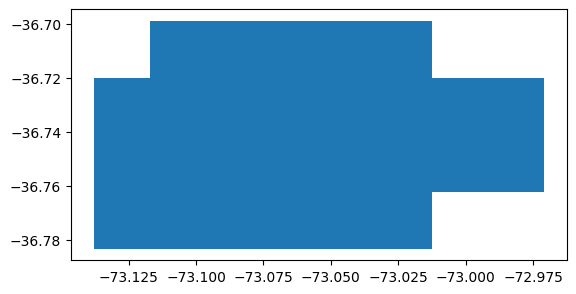

In [67]:
grid.plot();

In [49]:
coordenadas_lista = [[-73.15398858746755,-36.70643089922246],[-73.11974214276574,-36.70656852149412],[-73.12017129620828,-36.72363177314512],[-73.15707849225248,-36.72370056890712],[-73.15398858746755,-36.70643089922246]]

coordenadas_tuplas = tuple(coordenadas_lista)

print(coordenadas_tuplas)

([-73.15398858746755, -36.70643089922246], [-73.11974214276574, -36.70656852149412], [-73.12017129620828, -36.72363177314512], [-73.15707849225248, -36.72370056890712], [-73.15398858746755, -36.70643089922246])
